# Who Sent The Email and To Whom?

We will try to predict the senders and recipients of emails obtained from [Hillary Clinton Emails Dataset](https://www.kaggle.com/kaggle/hillary-clinton-emails).

In [98]:
%matplotlib inline

import csv
import pandas as pd
from datetime import datetime
import numpy as np
import re

from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

### Data Processing
We will keep track of 3 Dataframes:
* ``` all_emails: EmailId, EmailSubject, SenderId, SendDate, EmailBody, ReceiverId ```
* ``` all_people: PersonId, PersonName ```
* ``` all_emails_to_from: EmailId, ReceiverId ```

In [61]:
all_emails_metadata = []
with open('./Emails.csv', 'r') as f:
    data_reader = csv.reader(f)
    for row in data_reader:
        all_emails_metadata.append(row)

all_emails = pd.DataFrame(all_emails_metadata[1:], columns=all_emails_metadata[0])
all_emails = all_emails[['Id', 'MetadataSubject', 'SenderPersonId', 'MetadataDateSent', 'RawText']]
all_emails.columns = ['EmailId', 'EmailSubject', 'SenderId', 'SendDate', 'EmailBody']

In [62]:
all_people_metadata = []
with open('./Persons.csv', 'r') as f:
    data_reader = csv.reader(f)
    for row in data_reader:
        all_people_metadata.append(row)

all_people = pd.DataFrame(all_people_metadata[1:], columns=all_people_metadata[0])
all_people.columns = ['PersonId', 'PersonName']

In [63]:
all_emails_to_from_metadata = []
with open('./EmailReceivers.csv', 'r') as f:
    data_reader = csv.reader(f)
    for row in data_reader:
        all_emails_to_from_metadata.append(row)

all_emails_to_from = pd.DataFrame(all_emails_to_from_metadata[1:], columns=all_emails_to_from_metadata[0])

# drop columns not needed
all_emails_to_from.drop(
    'Id',
    axis=1,
    inplace=True
)
all_emails_to_from.columns = ['EmailId', 'ReceiverId']

In [64]:
# Join all_emails and all_emails_to_from with a right join on EmailId
all_emails = all_emails.merge(all_emails_to_from, on='EmailId', how='right')

In [65]:
# There are some fields that have empty values.
# Since there are not many of these cases, we will just drop the rows that have these empty values.
all_emails = all_emails[all_emails.SendDate != '']
all_emails = all_emails[all_emails.SenderId != '']
all_emails = all_emails[all_emails.ReceiverId != '']

# Convert all the dates with time to Timestamps.
# These can later be used to get date, time, etc...
all_emails.SendDate = [
    datetime.strptime(send_date.split('T')[0] + ' ' + send_date.split('T')[1].split('+')[0], '%Y-%m-%d %H:%M:%S')
    for send_date in all_emails.SendDate
]

In [66]:
# Convert all sender and receiver Ids to ints
all_emails.SenderId = [
    int(curr_sender_id)
    for curr_sender_id in all_emails.SenderId
]

all_emails.ReceiverId = [
    int(curr_recv_id)
    for curr_recv_id in all_emails.ReceiverId
]

### Data Transformation

Remove non-alphanumeric characters from strings and also remove strings that have numbers within them.

In [8]:
all_emails.EmailBody = [
    re.sub('[^A-Za-z0-9]+', ' ', line)
    for line in all_emails.EmailBody
]

# remove all words containing digits. these words would add noise.
all_emails.EmailBody = [
    ' '.join(s.lower() for s in line.split() if not any(c.isdigit() for c in s))
    for line in all_emails.EmailBody
]

### Predicting recipients of emails

In [71]:
h_emails = all_emails[all_emails.SenderId == 80][['EmailBody', 'ReceiverId']]

In [72]:
X_h_emails_train, X_h_emails_test, y_h_emails_train, y_h_emails_test = train_test_split(h_emails.EmailBody, h_emails.ReceiverId, test_size=0.25)

Creation of a document term matrix to store counts of words per document.

In [73]:
vect = CountVectorizer(stop_words='english')

vect.fit(X_h_emails_train)

CountVectorizer(analyzer=u'word', binary=False, charset=None,
        charset_error=None, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [74]:
X_h_emails_train_dtm = vect.transform(X_h_emails_train)
X_h_emails_test_dtm = vect.transform(X_h_emails_test)

We'll use Multinomial Naive Bayes for this prediction.

In [75]:
nb = MultinomialNB()

nb.fit(X_h_emails_train_dtm, y_h_emails_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [76]:
accuracy_score(nb.predict(X_h_emails_test_dtm), y_h_emails_test)

0.32944606413994171

Not a great prediction score. Moving on to [Pipelining](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html).

We will also use [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) to give proper weightage to terms in emails.

In [77]:
nb_pipeline = Pipeline([
        ('bow', CountVectorizer(stop_words='english', ngram_range=(1, 2))),
        ('tfidf', TfidfTransformer()),
        ('classifier', MultinomialNB())
])

In [78]:
nb_pipeline.fit(X_h_emails_train, y_h_emails_train)

Pipeline(steps=[('bow', CountVectorizer(analyzer=u'word', binary=False, charset=None,
        charset_error=None, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), prepr...         use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [79]:
accuracy_score(nb_pipeline.predict(X_h_emails_test), y_h_emails_test)

0.28425655976676384

Seems like predicting the recipients isn't working well. This might be because:
* A lot of emails were sent to a small proportion of recipients.
* Very few emails were sent to the large remaining portion of recipients

Let's see what [KDE](https://en.wikipedia.org/wiki/Kernel_density_estimation) tells us.

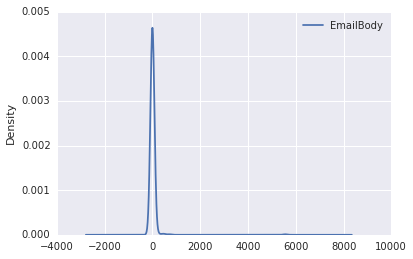

In [80]:
all_emails[['EmailBody', 'ReceiverId']].groupby('ReceiverId').count().plot(kind='kde')

That seems very prone to the hypothesis stated above. Moving on to predicting who sent the email.

### Predicting Senders of Emails

In [81]:
X_h_emails_train, X_h_emails_test, y_h_emails_train, y_h_emails_test = train_test_split(all_emails.EmailBody, all_emails.SenderId, test_size=0.25)

In [82]:
vect = CountVectorizer(stop_words='english')

vect.fit(X_h_emails_train)

CountVectorizer(analyzer=u'word', binary=False, charset=None,
        charset_error=None, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [83]:
X_h_emails_train_dtm = vect.transform(X_h_emails_train)
X_h_emails_test_dtm = vect.transform(X_h_emails_test)

In [84]:
X_h_emails_train_dtm

<6941x49929 sparse matrix of type '<type 'numpy.int64'>'
	with 851446 stored elements in Compressed Sparse Row format>

In [85]:
X_h_emails_test_dtm

<2314x49929 sparse matrix of type '<type 'numpy.int64'>'
	with 267678 stored elements in Compressed Sparse Row format>

In [86]:
nb = MultinomialNB()

nb.fit(X_h_emails_train_dtm, y_h_emails_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [94]:
y_pred_class_senders = nb.predict(X_h_emails_test_dtm)
accuracy_score(y_pred_class_senders, y_h_emails_test)

0.60847018150388932

Although not great, this is still better than what we saw earlier. Checking the KDE again.

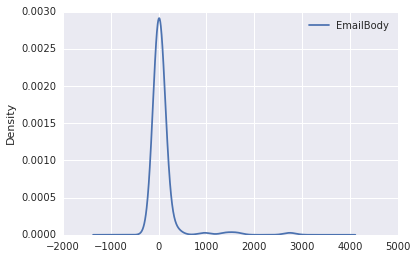

In [95]:
all_emails[['EmailBody', 'SenderId']].groupby('SenderId').count().plot(kind='kde')

This shows a slightly better distribution for prediction and that's why see a better accuracy score for predicting senders instead of recipients.

In [96]:
print (classification_report(y_pred_class_senders, y_h_emails_test))

             precision    recall  f1-score   support

          7       0.00      0.00      0.00         0
          9       0.00      0.00      0.00         0
         10       0.00      0.00      0.00         0
         12       0.00      0.00      0.00         0
         15       0.00      0.00      0.00         0
         16       0.09      1.00      0.17         1
         22       0.00      0.00      0.00         0
         24       0.00      0.00      0.00         0
         30       0.00      0.00      0.00         0
         32       0.72      0.71      0.72       363
         37       0.00      0.00      0.00         0
         39       0.00      0.00      0.00         0
         41       0.00      0.00      0.00         0
         42       0.00      0.00      0.00         0
         46       0.00      0.00      0.00         0
         48       0.00      0.00      0.00         0
         49       1.00      1.00      1.00         1
         63       0.00      0.00      0.00   